In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import dalex as dx

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 0. Przygotowanie Danych

In [ ]:
test_df = pd.read_csv('/datasets/data/UNSW_NB15_testing-set.csv', index_col=0)
train_df = pd.read_csv('/datasets/data/UNSW_NB15_training-set.csv', index_col=0)

Podział danych na treningowe, testowe i walidacyjne

In [ ]:
train_df, val_df = train_test_split(train_df, random_state=710, test_size=0.3)

In [ ]:
X_train = train_df.drop(columns=['label', 'attack_cat'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label', 'attack_cat'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label', 'attack_cat'])
y_test = test_df['label']

In [ ]:
numeric_columns = X_train.select_dtypes('number').columns
categorical_columns = X_train.select_dtypes('object').columns

#### 1. Feature Engineering

In [ ]:
mi = mutual_info_classif(X_train[numeric_columns], y_train)
mi = pd.Series(data = mi, index = numeric_columns)

Poniżej mamy funkcję do usuwania zmiennych silnie skorelowanych w lepszy niż losowy sposób.

To znaczy staramy się wpierw usuwać te najmniej znaczące.

In [ ]:
def remove_correlated_features(X, y = None, threshold = 0.65, features=numeric_columns, mi = None, corr_df = None):
    # at least one of 'y' and 'mi' must be not None
    assert(y is not None or mi is not None)
    if mi is None:
        mi = pd.Series(data = mutual_info_classif(X[features], y), index=features)
    if corr_df is None:
        corr_df = X.corr()

    # convert to an easier to use data frame
    corr_df = corr_df.melt(ignore_index=False).\
        reset_index(drop=False).\
        rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})

    # we look for all pairs of (different) features that are highly correlated
    corr_df = corr_df[
                (np.abs(corr_df['Corr']) > threshold) & 
                (corr_df['Var 1'] != corr_df['Var 2'])
        ].\
        sort_values(by='Corr', ascending=False)

    removed_features = set()

    # ALGORYTM 2
    # usuwamy atrybuty od najmniej ważnych tak długo jak są pary silnie skorelowane

    mi = mi.sort_values()
    correlated_features = set(corr_df['Var 1']).union(set(corr_df['Var 2']))

    i = 0 
    while corr_df.shape[0] > 0 and i < mi.shape[0]:
        feature = mi.index[i]
        i += 1
        if feature not in correlated_features:
            continue
        correlated_features.remove(feature)
        removed_features.add(feature)
        corr_df = corr_df[(corr_df['Var 1'] != feature) & (corr_df['Var 2'] != feature)]

    return X.drop(list(removed_features), axis=1), list(removed_features)

In [ ]:
X_train_reduced = remove_correlated_features(X_train, mi=mi)[0]
uncorrelated_columns = X_train_reduced.columns # to się przyda na potem

#### 2. Przygotowanie Pipelineów

In [ ]:
def create_column_transformer(columns_to_use):
    numeric_columns_to_use = np.intersect1d(columns_to_use, numeric_columns)
    categorical_columns_to_use = np.intersect1d(columns_to_use, categorical_columns)
    
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_columns_to_use),
            ("cat", OneHotEncoder(drop='first'), categorical_columns_to_use),
        ],
        remainder='drop'
    )

In [ ]:
columns_to_use = np.intersect1d(uncorrelated_columns, mi[mi > 0.2].sort_values(ascending=False).index)

#### 2.1 Przygotowanie Modelu XGBoost

In [ ]:
xgb_clf = Pipeline(
    steps=[
        ("preprocessor", create_column_transformer(columns_to_use)),
        ("classifier", XGBClassifier(random_state=710, eval_metric='logloss', use_label_encoder=False))
    ]
)

In [ ]:
# funkcja pomocnicza do ewaluacji modelu

def statistics_classification(y, y_pred, y_pred_proba):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    axes[0].plot(fpr,tpr)
    axes[0].set_title('ROC curve')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    # plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(ax = axes[1], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not an attack)', '1 (Attack)'], yticklabels=['0 (Not an attack)', '1 (Attack)'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion matrix')
    plt.show()

    # display metrics
    auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    matthews_coef = matthews_corrcoef(y, y_pred)

    print(f'{auc=}\n')
    print(f'{accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')
    print(f'{matthews_coef=}')

fitted


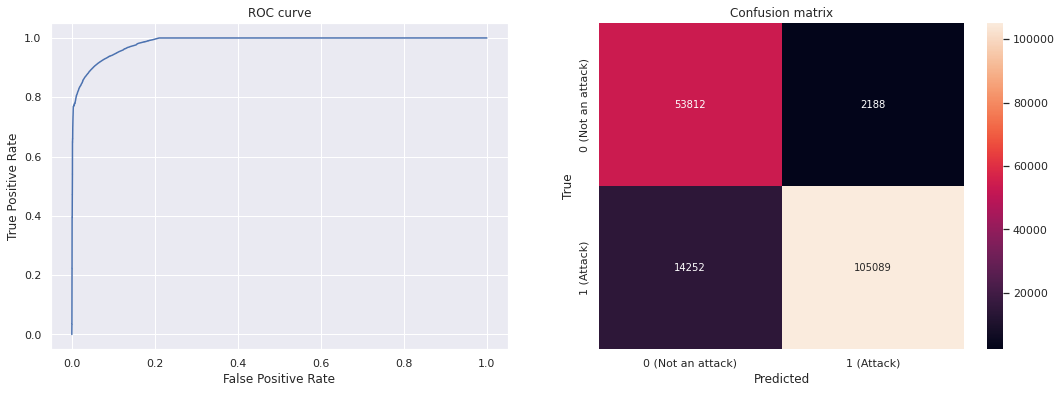

auc=0.9848313078249962

accuracy=0.9062398412236727
recall=0.8805775047971779
f1=0.9274550123997212
matthews_coef=0.8050707757358744


In [ ]:
xgb_clf.fit(X_train, y_train)
print("fitted")
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[::, 1]

statistics_classification(y_test, y_pred, y_pred_proba)

# XAI

Najlepszy model to model domyślny, dlatego to go będziemy wytłumaczać

In [ ]:
# dane po przejściu przez preprocessor stają się tablicą numpy'ową i utracona zostaje informacja
# która kolumna co reprezentuje, ta funkcja pozwala odzyskać tę informację

# z tego co zrozumiałem z patch notesów od sklearna 1.1 zadanie to da się zrealizować prościej
# niż za pomocą poniższej funkcji, ale nie zdążyłem jeszcze dokładnie zapoznać się z nową wersją

def get_feature_names(column_transformer):
    # helper function
    def get_names(trans):
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return [f"x{i}" for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            warnings.warn(f"Transformer {name} (type {type(trans).__name__}) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available")
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    # start of processing
    feature_names = []
    
    # handle Pipelines
    if type(column_transformer) == Pipeline:
        transformers = [(name, trans, None, None) for _, name, trans in column_transformer._iter()]
    else:
        # handle regular transformers
        transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in transformers: 
        if type(trans) == Pipeline:
            # Recursive call on a Pipeline
            _names = get_feature_names(trans)
            # if the pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
preprocessor = xgb_clf[0]
model = xgb_clf[1]

In [ ]:
col_names = get_feature_names(preprocessor)

X_train_ = pd.DataFrame(preprocessor.transform(X_train), columns=col_names)
X_val_ = pd.DataFrame(preprocessor.transform(X_val), columns=col_names)
X_test_ = pd.DataFrame(preprocessor.transform(X_test), columns=col_names)

Transformer num (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [ ]:
np.random.seed(42)
samples_idx = np.random.randint(len(X_test_), size=1000)
samples = X_test_.iloc[samples_idx]

In [ ]:
exp_shap = shap.Explainer(model.predict, X_train_)
shap_values = exp_shap(samples)

Permutation explainer: 1001it [04:40,  3.49it/s]


In [ ]:
# cofamy skalowanie, żeby dane na wykresach były czytelniejsze
shap_values.data = preprocessor.named_transformers_['num'].inverse_transform(shap_values.data)

In [ ]:
exp_dx = dx.Explainer(model, X_train_, y_train)

Preparation of a new explainer is initiated

  -> data              : 57632 rows 12 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 57632 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fe97a7f48b0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.9e-06, mean = 0.55, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.993, mean = 6.63e-06, max = 0.957
  -> model_info        : package xgboost

A new explainer has been created!


Sprawdźmy kilka losowych obserwacji oraz ich wyjaśnienia dostarczorne przez pakiety `SHAP` i `DALEX`

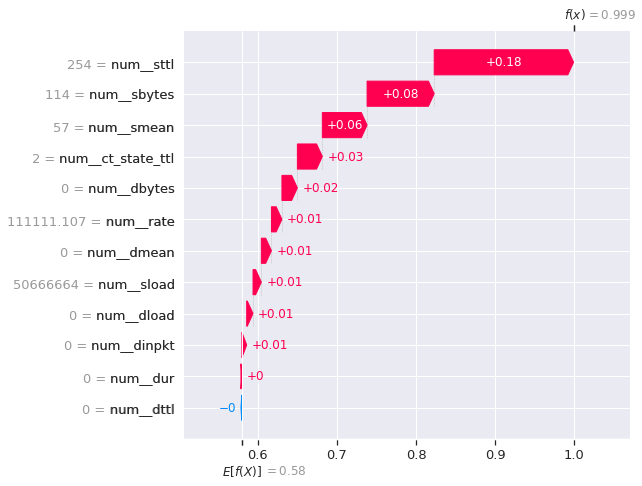

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=14)

In [ ]:
dx_sample_1 = exp_dx.predict_parts(samples.iloc[0], type='break_down')
dx_sample_1.plot(max_vars = 5)

Oba pakiety są zgodne co to tego, że na wzrost prawdopodobieństwa ataku miały wpływ zmienne `sttl`, `sbytes` oraz `smean`, choć `SHAP` wyskazuje jeszcze kilka innych zmiennych, które do owego wzrostu się przyczyniły, podczas gdy `DALEX` je marginalizuje.

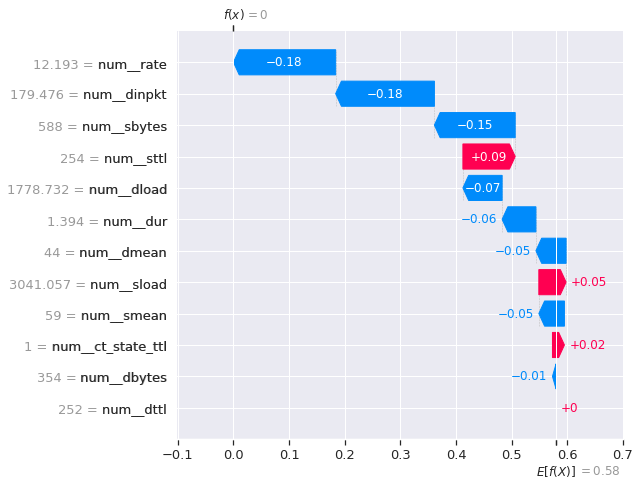

In [ ]:
shap.plots.waterfall(shap_values[7], max_display=14)

In [ ]:
dx_sample_3 = exp_dx.predict_parts(samples.iloc[7], type='break_down')
dx_sample_3.plot(max_vars = 22)

W przypadku `SHAPa` zmienne `rate`, `dinpkt` oraz `sbytes` znacząco zmiejszyły prawdopodobieństwo ataku, podczas gdy `sttl` i `sload` owo prawdopodobieństwo zwiększały. `DALEX` wykrył również zmienną `dload` jako tą, która przyczyniła się do spadku prawdopodobieństwa ataku, a także uznał, że zmienna `rate` do tego się nie przyczyniła. Ten pakiet wskazał również, że zmienna `smean` przybliżała obserwację do uznania za atak, czego `SHAP` nie pokazał. 

#### Beeswarm

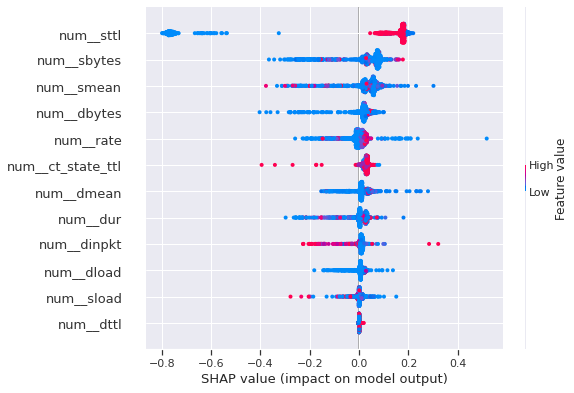

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

Analizując powyższy wykres możemy zauważyć, że zmienna `sttl` zazwyczaj z dokładnością co do znaku osiąga bardzo duży SHAP value, co sugeruje, że istotnie wpływa ona na predykcje modelu.

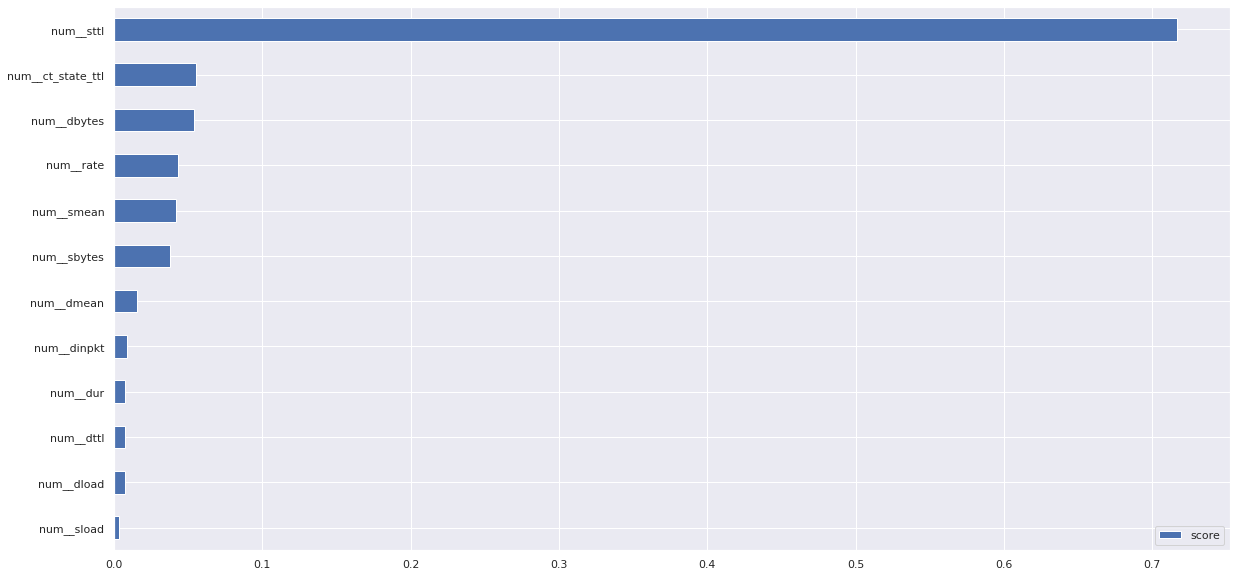

In [ ]:
feature_importances = pd.DataFrame(
        data=model.feature_importances_,
        index=col_names,
        columns=["score"]
    ).sort_values(by='score')

feature_importances.plot(kind='barh', figsize = (20,10))
plt.show()

Analiza `fearure importances`, potwierdza przypuszczenie wysnute na podstawie wykresu beeswarm.

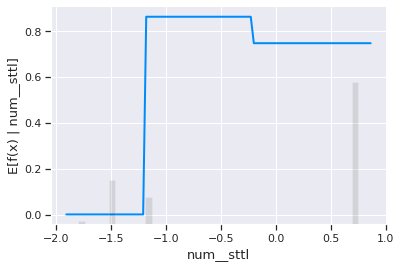

In [ ]:
shap.partial_dependence_plot(
    11,
    model.predict,
    X_train_,
    ice=False,
    # model_expected_value=True,
    # feature_expected_value=True
)

Analizując wykres częściowej zależności zmiennej sttl, możemy zauważyć, że oczekiwana wartość przewidziana przez model wynosi 0, kiedy wartość zestandaryzowanej zmiennej `sttl` jest poniżej około -1.2, natomiast gdy przekracza ona tę wartość, to wówczas wartość oczekiwana modelu oscyluje wokół 0.8.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c1ba39a3-4988-442b-a516-cd71d37305ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>